#  Project group 30 
## Image colorization by combining semantic segmentation and autoencoding 

Install dependencies

In [1]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch import optim
import torchvision.transforms
from torchvision.transforms import Compose

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from PIL import Image, ImageOps 

In [2]:
train_path = "\Train"

val_path = "\Validation"

test_path = "\Test"

In [3]:
# !pip install kornia
import torch.utils.data as data
import glob
import os
from matplotlib.colors import LinearSegmentedColormap
import kornia
from torchvision.transforms import RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize
import torchvision.transforms as transforms

class DataLoaderSegmentationAndColorisation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentationAndColorisation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) # PIL images
            SEG = Image.open(mask_path)
        
            if self.transform is not None:
                data = self.transform(data)
                SEG = self.transform(SEG) # segmentation should probably only be resized

            # SOMETHING FISHY HERE
            transform = transforms.Compose([ 
                transforms.PILToTensor() 
            ]) 

            img_lab = kornia.color.rgb_to_lab(transform(data))

            L = (img_lab.permute(1, 2, 0))[:,:,0]
            A = (img_lab.permute(1, 2, 0))[:,:,1]
            B = (img_lab.permute(1, 2, 0))[:,:,2]

            SEG = transform(SEG)
            SEG = torch.squeeze(SEG)

            input = torch.stack((L,SEG))
            output = torch.stack((A,B))

            
            # data = [L and seg] label = [A, B]
            input = input.to(torch.float32) 
            output = output.to(torch.float32)       
            return input, output

    def __len__(self):
        return len(self.img_files)

example_transform = Compose([Resize((128,128), antialias=True)])
example_dataset = DataLoaderSegmentationAndColorisation(train_path,example_transform)

input, output = example_dataset[30]

In [15]:

batch_size = 16
#n_classes = 35 # Only for segmentation
img_size = 128 #256 later

train_transforms = Compose([Resize((img_size,img_size), antialias=True)])

example_transform = Compose([Resize((128,128), antialias=True)])
example_dataset = DataLoaderSegmentationAndColorisation(train_path,example_transform)

input, output = example_dataset[30]

print(input.shape)
print(output.shape)

train_set = DataLoaderSegmentationAndColorisation(train_path, train_transforms)
val_set = DataLoaderSegmentationAndColorisation(val_path, train_transforms)


train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

torch.Size([2, 128, 128])
torch.Size([2, 128, 128])


In [74]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs) 
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

    
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(2, 64) # Maybe 2 since L and SEG
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, 2, kernel_size=1, padding=0) # 2 since A and B
    def forward(self, inputs):
        """ Encoder """
        #print(inputs.shape)
        #inputs = inputs.permute(1,0,2,3)
        inputs = torch.squeeze(inputs)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [89]:
#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#cmap = get_cmap(n_classes)

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        # Validate fucks up
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              #f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Save model to disk after each epoch
        torch.save(model.state_dict(), 'segmentation_model.pth')
        
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):    
        inputs, labels = x.to(device), y.to(device)
        inputs = inputs[None, :]
        
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())


        print("Thinking.... ", batch_index)
        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            inputs = inputs[None, :]
            
            z = model.forward(inputs)
            z = torch.round(z)
            batch_loss = loss_fn(z, labels.long()) 
            val_loss_cum += batch_loss.item()      
            
            # Visual test
            if batch_index == 1:
                z, _ = torch.max(z[0,:,:,:],dim=0)

                # Shapes
                inputs = torch.squeeze(inputs)
                #print("inputs shape: ", inputs.shape) # [16, 2, 128, 128] [Batch, (L, SEG), img, img]
                #print("labels shape: ", labels.shape) # [16, 2, 128, 128] [Batch, (A, B), img, img]
                
                L_true = inputs[0,0,:,:] # [128, 128] [img, img]
                A_true = labels[0,0,:,:] # [128, 128] [img, img]
                B_true = labels[0,1,:,:] # [128, 128] [img, img]

                print("L first pixel: ", L_true[0,0]) # 3045.8210
                print("A first pixel: ", A_true[0,0]) # -84.5547
                print("B first pixel: ", B_true[0,0]) # -636.1595

                #LAB = torch.stack((L_true*0.01, A_true, B_true),0) # [3, 128, 128]
                target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)
                
                f, axarr = plt.subplots(1,4)
                axarr[0].imshow(L_true,'grey')         # L input
                axarr[1].imshow(inputs[0,1,:,:])     # SEG input
                axarr[2].imshow(target_img) # Output picture (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
                axarr[3].imshow(target_img) # Facit picture

                plt.show()
                # Save the model each time we plot (REMOVE LATER)
                torch.save(model.state_dict(), 'segmentation_model.pth')

    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

creating new model
Starting training
Thinking....  1
L first pixel:  tensor(3045.8210)
A first pixel:  tensor(-84.5547)
B first pixel:  tensor(-636.1595)


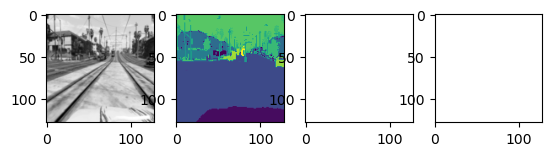

KeyboardInterrupt: 

In [90]:
train_from_disk = False

if train_from_disk:  
    # Read model from disk
    print("reding model from disk")
    pretrained = torch.load('segmentation_and_color_model.pth', map_location=lambda storage, loc: storage)
    Segmentaion_and_color_model = build_unet()
    Segmentaion_and_color_model.load_state_dict(torch.load('segmentation_and_color_model.pth'))
else:
    # Create new model
    print("creating new model")
    Segmentaion_and_color_model = build_unet()



optimizer = optim.Adam(Segmentaion_and_color_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss() # kass som faen men int nu
#loss_fn = nn.CrossEntropyLoss() # mindre kass
train_loader = train_dataloader 
val_loader = val_dataloader
num_epochs = 10
print_every = 1

Segmentaion_and_color_model, Segmentaion_and_color_train_losses, Segmentaion_and_color_train_accs, Segmentaion_and_color_val_losses, Segmentaion_and_color_val_accs= training_loop(Segmentaion_and_color_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)
